In [206]:
import numpy as np
import glob
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import pyproj as proj
from scipy.stats import norm

def folder2cube(files, size_raster):
    base_set = glob.glob(files)
    cube = np.zeros(size_raster + (len(base_set),))
    for i, model in enumerate(base_set): 
        cube[:,:,i] = np.loadtxt(model, skiprows = 1).reshape(size_raster)
    return cube, len(base_set)

def show_it(data, turn = True):
    if turn:
        plt.imshow(data.T, origin="upper")
    else:
        plt.imshow(data, origin="upper")
    plt.colorbar()
    plt.show()
    
size_raster = (250,162)


In [200]:
base_cube, base_n = folder2cube('data/Hackaton/BaseSet/MapSimu__*.data',size_raster)
top_cube, top_n = folder2cube('data/Hackaton/TopSet/MapSimu__*.data',size_raster)


In [138]:
volume_file = 'data/Hackaton/VolumeDistribution/Volumes'

vol = pd.read_csv(volume_file, delim_whitespace=True)

In [192]:
ds = xr.Dataset()  

X_corner = 390885
Y_corner = 7156947
dx, dy = 25, 25

#top_model = np.min([np.min(base_cube),np.min(top_cube)])
#bottom_model = np.max([np.max(base_cube),np.max(top_cube)])

top_model = 950
bottom_model = 1050
dz = 100


xx = np.linspace(X_corner, X_corner+size_raster[0]*dx, size_raster[0])
yy = np.linspace(Y_corner, Y_corner+size_raster[1]*dy, size_raster[1])
zz = np.linspace(top_model, bottom_model, dz)

model = np.linspace(0, top_model, base_n)

ds.coords['X'] = xx
ds.coords['Y'] = yy
ds.coords['Z'] = zz
ds.coords['MODEL'] = model

ds['BASE'] = (('X', 'Y', 'MODEL'), base_cube)
ds['TOP'] = (('X', 'Y', 'MODEL'), top_cube)


In [193]:
base_mean = ds['BASE'].mean(dim='MODEL')
base_std = ds['BASE'].std(dim='MODEL')

top_mean = ds['TOP'].mean(dim='MODEL')
top_std = ds['TOP'].std(dim='MODEL')


In [248]:
954.04040404-950

4.0404040399999985

In [220]:
top_cloud = np.zeros(size_raster + (dz,))
base_cloud = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        top_cloud[x,y,:] = norm.pdf(zz,top_mean.values[x,y],top_std.values[x,y])

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        base_cloud[x,y,:] = norm.pdf(zz,base_mean.values[x,y],base_std.values[x,y])


/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1652: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [221]:
top_unit = np.zeros(size_raster + (dz,))
base_unit = np.zeros(size_raster + (dz,))

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        top_unit[x,y,:] = 1 - norm.cdf(zz,top_mean.values[x,y],top_std.values[x,y])

for x in range(0,len(xx)):
    for y in range(0,len(yy)):
        base_unit[x,y,:] = norm.cdf(zz,base_mean.values[x,y],base_std.values[x,y])
        
mid_unit = 1 - top_unit - base_unit


/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1735: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


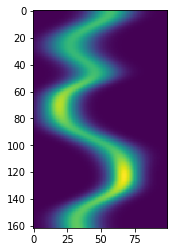

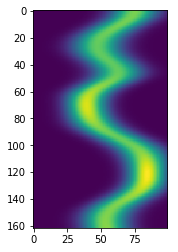

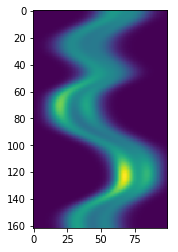

In [197]:
plt.imshow(top_cloud[50,:,:])
plt.show()

plt.imshow(base_cloud[50,:,:])
plt.show()


plt.imshow(0.5*(base_cloud[50,:,:]**2+top_cloud[50,:,:]**2))
plt.show()

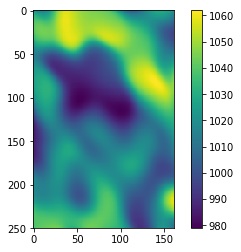

In [198]:
plt.imshow(ds['BASE'][dict(MODEL=130)])
plt.colorbar()
plt.show()

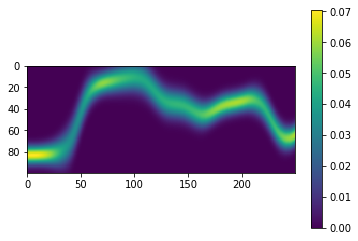

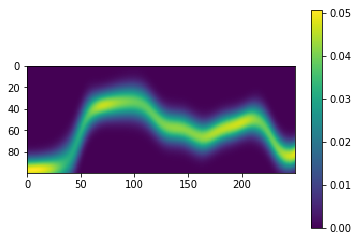

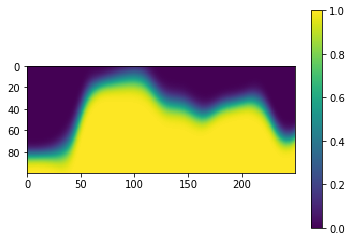

In [210]:
show_it(top_cloud[:,50,:])
show_it(ba_cloud[:,50,:])
show_it(base_cloud[:,50,:])

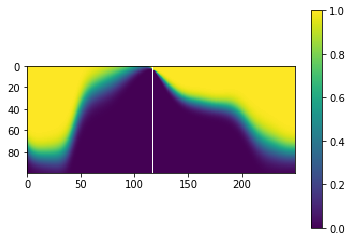

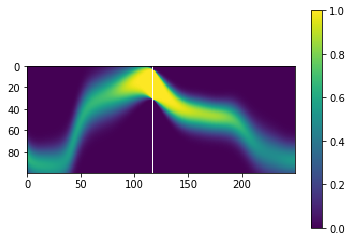

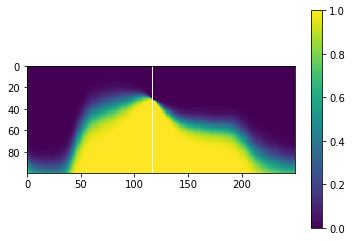

In [232]:
#170, 93

show_it(top_unit[:,93,:])
show_it(mid_unit[:,93,:])
show_it(base_unit[:,93,:])

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


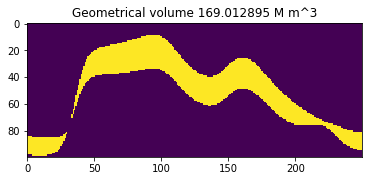

In [295]:
P_gate = 0.5

unit_poly = np.where(mid_unit>P_gate, mid_unit, 0).astype('bool')

np.shape(unit_poly)

the_volume = unit_poly.sum()*25*25*4.04/10e6

plt.imshow(unit_poly[:,72].T, origin="upper")
plt.title('Geometrical volume %s M m^3' %the_volume)
plt.show()